# CNN Modelling

This project is for creating a CNN classifier for gesture recognition

In [1]:
# Imports
from pathlib import Path
import os
import pickle
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample, decimate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)

In [2]:
dataset = pd.read_pickle('dataset.pkl')

In [3]:
def reshape_windows_tensor_with_labels(data, y):
    """
    Converts data from:
        recordings x windows x channels x samples
    to:
        total_windows x channels x samples
    """
    X_windows = []
    y_windows = []
    data = data.to_list()
    y = y.to_list()
    for rec_idx, rec in enumerate(data):
        rec = np.asarray(rec)
        if rec.shape[0] == 0:
            continue

        for window in rec:
            X_windows.append(window)
            y_windows.append(y[rec_idx])

    return np.asarray(X_windows), np.asarray(y_windows)

(1038,)


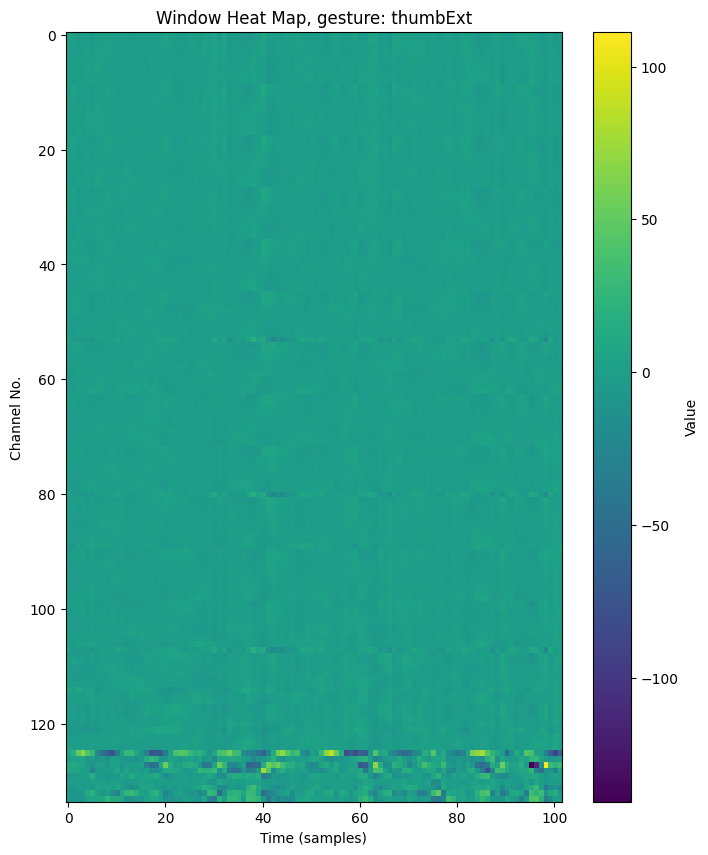

In [4]:
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_raw'], dataset['movement'], test_size=0.2, random_state=42)

print(X_train.shape)

X_train, y_train = reshape_windows_tensor_with_labels(X_train, y_train)
data = X_train[0]

plt.figure(figsize=(8, 10))
plt.imshow(data, aspect='auto', cmap='viridis')
plt.colorbar(label='Value')
plt.title(f'Window Heat Map, gesture: {y_train[0]}')
plt.xlabel('Time (samples)')
plt.ylabel('Channel No.')
plt.show()


In [5]:
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_raw'], dataset['movement'], test_size=0.2, random_state=42)
X_train, y_train = reshape_windows_tensor_with_labels(X_train, y_train)
X_test, y_test = reshape_windows_tensor_with_labels(X_test, y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(42707, 134, 102)
(42707,)
(10229, 134, 102)
(10229,)


In [6]:
print("Per-trial containers:")
print("X_train:", type(X_train), getattr(X_train, "shape", None))
print("y_train:", type(y_train), getattr(y_train, "shape", None))

# Convert from per-trial -> per-window (ready for CNN)
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_raw'], dataset['movement'], test_size=0.2, random_state=42)
X_train, y_train = reshape_windows_tensor_with_labels(X_train, y_train)
X_test, y_test = reshape_windows_tensor_with_labels(X_test, y_test)

print("\nPer-window tensors (CNN-ready):")
print("X_train shape:", X_train.shape)  # expected: (N_windows, C, T)
print("y_train shape:", y_train.shape)  # expected: (N_windows,)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Quick sanity check of channel/time dims
if X_train.ndim == 3:
    N, C, T = X_train.shape
    print(f"\nCNN expects [N, C, T] -> N={N}, C={C}, T={T}")
else:
    print("\nUnexpected X_train ndim:", X_train.ndim)

Per-trial containers:
X_train: <class 'numpy.ndarray'> (42707, 134, 102)
y_train: <class 'numpy.ndarray'> (42707,)

Per-window tensors (CNN-ready):
X_train shape: (42707, 134, 102)
y_train shape: (42707,)
X_test shape: (10229, 134, 102)
y_test shape: (10229,)

CNN expects [N, C, T] -> N=42707, C=134, T=102


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_raw'], dataset['movement'], test_size=0.2, random_state=42)
X_train, y_train = reshape_windows_tensor_with_labels(X_train, y_train)
X_test, y_test = reshape_windows_tensor_with_labels(X_test, y_test)

# Encode labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1)  # Add channel dimension: (N, 1, 134, 102)
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(1)
y_train_tensor = torch.LongTensor(y_train_encoded)
y_test_tensor = torch.LongTensor(y_test_encoded)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# DEFINE THE FUNCTIONS

def make_better_cnn_model(num_classes):
    # Input shape: (batch, 1, 134, 102)
    # After MaxPool2d(2,2): (67, 51)
    # After second MaxPool2d(2,2): (33, 25)
    # After third MaxPool2d(2,2): (16, 12)
    # Flattened size: 128 * 16 * 12 = 24576
    
    m = nn.Sequential(
        # First conv block
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(0.2),
        
        # Second conv block
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(0.3),
        
        # Third conv block
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(0.4),
        
        # Fully connected layers
        nn.Flatten(),
        nn.Linear(in_features=24576, out_features=256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(in_features=256, out_features=num_classes),
    )
    return m

def train_model_gpu(model, criterion, accuracy_fn, optimizer, train_loader, test_loader, num_epochs=150, batch_print=100):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            if (batch_idx + 1) % batch_print == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss /= len(test_loader)
        val_acc = 100 * val_correct / val_total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    return history

def cross_entropy_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

In [ ]:
# Create and move model to GPU
better_cnn_model = make_better_cnn_model(num_classes).to(device)
optimizer = optim.Adam(better_cnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Print model summary
print(f"\nModel architecture:")
print(better_cnn_model)
print(f"\nTotal parameters: {sum(p.numel() for p in better_cnn_model.parameters())}")

# Train the model
history = train_model_gpu(
    better_cnn_model, 
    criterion, 
    cross_entropy_accuracy, 
    optimizer, 
    train_loader, 
    test_loader, 
    num_epochs=150, 
    batch_print=100,
)